# Setup

In [11]:
import pandas as pd
from ortools.linear_solver import pywraplp
import time

# Production Planning

## BOM
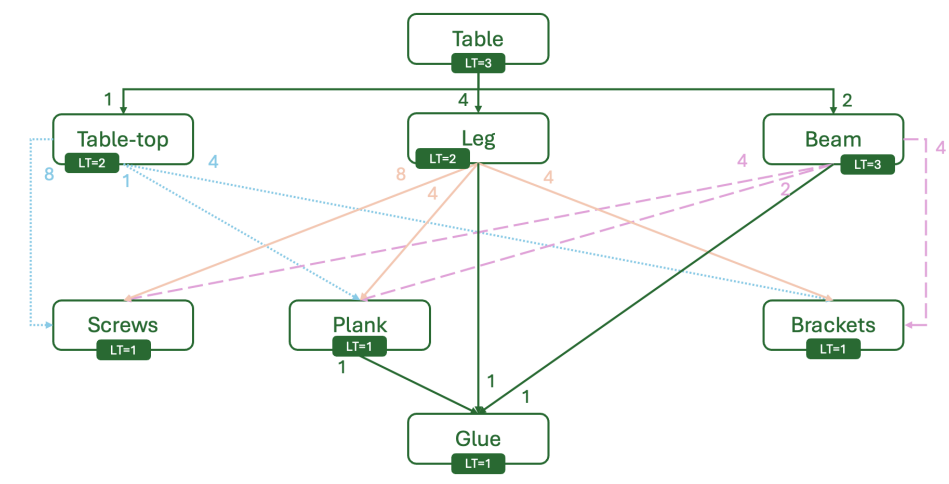

## Table 1: Demand of new Table in the upcoming 16 days
| Period   | 1  | 2  | 3  | 4  | 5  | 6  | 7  | 8  | 9  | 10 | 11 | 12 | 13 | 14 | 15 | 16 |
|----------|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|----|
| Demand   | 0  | 0  | 0  | 0  | 0  | 18 | 15 | 16 | 12 | 14 | 19 | 10 | 13 | 11 | 17 | 12 |

## Table 2: Information regarding production of the new table
| Product/material | Table | Tabletop | Leg | Beams | Screws | Brackets | Planks | Glue |
|------------------|-------|----------|-----|-------|--------|----------|--------|------|
| Lead-time        | 3     | 2        | 2   | 3     | 1      | 1        | 1      | 1    |
| Initial inventory| 0     | 20       | 100 | 70    | 50     | 100      | 50     | 100  |
| Production cost  | 100   | 100      | 100 | 100   | 100    | 100      | 100    | 100  |
| Inventory cost   | 20    | 10       | 10  | 10    | 5      | 5        | 5      | 5    |
| Setup cost       | 500   | 200      | 200 | 200   | 200    | 200      | 200    | 200  |


## Question 1

1. Determine the production and ordering plans for the table and its sub-materials. Solve
the optimal integrated model and also utilize the decomposition approach. Describe the
results, highlighting the differences.

From now on, continue with the optimal method and retain the input of each question for
the subsequent ones.

In [47]:
def opt_production_plan(data):

    # Create the mip solver with the SCIP backend.
    m = pywraplp.Solver.CreateSolver('SCIP')

    # decision variables
    obj = m.NumVar(0, 1000000000, 'obj')

    setup = []
    production = []
    inventory = []
    for product in range(len(data.demands)):
      setup_temp = []
      production_temp = []
      inventory_temp = []
      for day in range(len(data.days)):
          suffix = '_{}_{}'.format(product, day)
          setup_temp.append(m.BoolVar('setup' + suffix))
          production_temp.append(m.NumVar(0, 100000, 'production' + suffix))
          inventory_temp.append(m.NumVar(0, 100000, 'inventory' + suffix))

      setup.append(setup_temp)
      production.append(production_temp)
      inventory.append(inventory_temp)


    # constraints
    m.Add(obj >= sum(
        sum(setup[product]) * data.setup_cost[product] + \
        sum(inventory[product][:-1] * data.inventory_cost[product])
          for product in range(len(data.demands))))

    # Demand constraint
    for product in range(len(data.demands)):
      for day in data.days:
        # Setup constraint
        m.Add(production[product][day] <= 100000 * setup[product][day])

        if day != 0:
          if day - data.lead_time[product] >= 0:
              m.Add(inventory[product][day-1] + production[product][day - data.lead_time[product]] == \
                    (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
          else:
            m.Add(inventory[product][day-1] == (data.demands[product][day] + sum(data.parts[unit][product] * production[unit][day] for unit in range(len(data.demands)))) + inventory[product][day])
        else:
          m.Add(data.first_inventory[product] == (data.demands[product][0] + sum(data.parts[unit][product] * production[unit][0] for unit in range(len(data.demands)))) + inventory[product][0])




    # objective function
    m.Minimize(obj)

    # solving the model
    status = m.Solve()

    if status == pywraplp.Solver.OPTIMAL:

        PRODUCTION_PLAN = {}
        for product in range(len(data.demands)):
          PRODUCTION_PLAN_temp = {}
          for m_idx, day in enumerate(data.days):
              PRODUCTION_PLAN_temp[day] = {
                  'product ' + str(product):   production[product][m_idx].solution_value(), \
                  'setup':                     setup[product][m_idx].solution_value(), \
                  'inventory':                 inventory[product][m_idx].solution_value()
                  }
          PRODUCTION_PLAN[product] = PRODUCTION_PLAN_temp
        return PRODUCTION_PLAN, obj.solution_value()

    else:
        print('The problem does not have an optimal solution.')

In [59]:
class ProjectData:

  def __init__(self):

    self.demands = [
            [0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12],  # Table demand
            [0]*16,  # Tabletop demand (calculated)
            [0]*16,  # Leg demand (calculated)
            [0]*16,  # Beam demand (calculated)
            [0]*16,  # Screw demand (calculated)
            [0]*16,  # Plank demand (calculated)
            [0]*16,  # Bracket demand (calculated)
            [0]*16   # Glue demand (calculated)
        ]

    self.days = range(len(self.demands[0]))

    self.parts = [
            [0, 1, 4, 2, 0, 0, 0, 0],  # Table
            [0, 0, 0, 0, 8, 1, 4, 0],  # Tabletop
            [0, 0, 0, 0, 8, 4, 4, 1],  # Leg
            [0, 0, 0, 0, 4, 2, 4, 1],  # Beam
            [0, 0, 0, 0, 0, 0, 0, 0],  # Screws
            [0, 0, 0, 0, 0, 0, 0, 1],  # Plank
            [0, 0, 0, 0, 0, 0, 0, 0],  # Brackets
            [0, 0, 0, 0, 0, 0, 0, 0]   # Glue
        ]

    self.lead_time = [3, 2, 2, 3, 1, 1, 1, 1]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0, 20, 100, 70, 50, 100, 50, 100]
    self.inventory_cost = [20, 10, 10, 10, 5, 5, 5, 5]
    self.setup_cost = [500, 200, 200, 200, 200, 200, 200, 200]

### Optimum

In [60]:
start_time = time.time()
data = ProjectData()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,20.0,0.0,0.0,13.0,16.0,55.0,0.0,0.0,0.0,53.0,-0.0,0.0,-0.0,0.0,0.0,0.0
setup,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,20.0,20.0,2.0,0.0,0.0,43.0,29.0,10.0,0.0,40.0,29.0,12.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 1,6.0,7.0,16.0,55.0,0.0,0.0,0.0,53.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,6.0,0.0,-0.0,0.0,0.0,0.0,-0.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 2,-0.0,33.0,63.0,220.0,0.0,0.0,0.0,212.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,20.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 3,0.0,28.0,110.0,0.0,0.0,0.0,106.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,30.0,30.0,30.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 4,429.0,1073.0,2200.0,0.0,0.0,424.0,2120.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 5,100.0,489.0,935.0,0.0,0.0,212.0,901.0,-0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,94.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 6,246.0,756.0,1100.0,0.0,0.0,424.0,1060.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 7,550.0,1108.0,220.0,0.0,212.0,1007.0,212.0,0.0,0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,-0.0,-0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  15396 . Run time is :  14.336862325668335


## Decomposition
### MPS

In [62]:
class data_generator_MPS():

  def __init__(self):

    self.demands = [[0, 0, 0, 0, 0, 18, 15, 16, 12, 14, 19, 10, 13, 11, 17, 12]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [3]

    self.production_cost = [100] * len(self.demands)
    self.first_inventory = [0]
    self.inventory_cost = [20] * len(self.demands)
    self.setup_cost = [500] * len(self.demands)

start_time = time.time()
data = data_generator_MPS()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,0.0,33.0,0.0,28.0,0.0,14.0,29.0,0.0,24.0,0.0,29.0,0.0,0.0,0.0,0.0
setup,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
inventory,0.0,0.0,0.0,0.0,0.0,15.0,0.0,12.0,0.0,0.0,10.0,0.0,11.0,0.0,12.0,0.0


objective is :  4200 . Run time is :  0.04064631462097168


## MRP
### table top

In [65]:
class data_generator_MRP_tabelT():

  def __init__(self):

    self.demands = [[0, 0, 33, 0, 28, 0, 14, 29, 0, 24, 0, 29, 0, 0, 0, 0]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [2]



    self.first_inventory = [20]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_tabelT()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

print('Table top obj fct: ')
run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

Table top obj fct: 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,13.0,0.0,28.0,0.0,14.0,29.0,0.0,24.0,0.0,29.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,20.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


objective is :  1600 . Run time is :  0.02134394645690918


### Leg

In [66]:
class data_generator_MRP_leg():

  def __init__(self):

    self.demands = [[0.0, 0.0, 132.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0]
]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [2]



    self.first_inventory = [100]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_leg()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,32.0,0.0,112.0,0.0,56.0,116.0,0.0,96.0,0.0,116.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,100.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


objective is :  3200 . Run time is :  0.0205996036529541


### Beams

In [67]:
class data_generator_MRP_beam():

  def __init__(self):

    self.demands = [[0.0, 0.0, 66.0, 0.0, 56.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0]]

    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [3]

    self.first_inventory = [70]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [10] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_beam()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
product 0,0.0,52.0,0.0,28.0,58.0,0.0,48.0,0.0,58.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
setup,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
inventory,70.0,70.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.0,-0.0,-0.0,-0.0,-0.0


objective is :  2480 . Run time is :  0.015332937240600586


### Screws

In [71]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 8 for num in list1]
list2_multiplied = [num * 8 for num in list2]
list3_multiplied = [num * 4 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
combined_list

[360.0,
 208.0,
 1120.0,
 112.0,
 792.0,
 1160.0,
 192.0,
 960.0,
 232.0,
 1160.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [72]:
class data_generator_MRP_screws():

  def __init__(self):

    self.demands = [[360, 208, 1120, 112, 792, 1160, 192, 960, 232, 1160, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_screws()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

The problem does not have an optimal solution.


TypeError: cannot unpack non-iterable NoneType object

### Plank

In [73]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 1 for num in list1]
list2_multiplied = [num * 4 for num in list2]
list3_multiplied = [num * 2 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
combined_list

[141.0,
 104.0,
 476.0,
 56.0,
 354.0,
 493.0,
 96.0,
 408.0,
 116.0,
 493.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [74]:
class data_generator_MRP_planks():

  def __init__(self):

    self.demands = [[141, 104, 476, 56, 354, 493, 96, 408, 116, 493, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

The problem does not have an optimal solution.


TypeError: cannot unpack non-iterable NoneType object

### Brackets

In [75]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# Multiply each list by the specified factor
list1_multiplied = [num * 4 for num in list1]
list2_multiplied = [num * 4 for num in list2]
list3_multiplied = [num * 4 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
combined_list

[180.0,
 208.0,
 560.0,
 112.0,
 512.0,
 580.0,
 192.0,
 480.0,
 232.0,
 580.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [76]:
class data_generator_MRP_planks():

  def __init__(self):

    self.demands = [[180, 208, 560, 112, 512, 580, 192, 480, 232, 580, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)

The problem does not have an optimal solution.


TypeError: cannot unpack non-iterable NoneType object

### Glue

In [ ]:
# demand for screws for each table_top, legs and beams
list1 = [13.0, 0.0, 28.0, 0.0, 14.0, 29.0, 0.0, 24.0, 0.0, 29.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list2 = [32.0, 0.0, 112.0, 0.0, 56.0, 116.0, 0.0, 96.0, 0.0, 116.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
list3 = [0.0, 52.0, 0.0, 28.0, 58.0, 0.0, 48.0, 0.0, 58.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


# Multiply each list by the specified factor
list1_multiplied = [num * 4 for num in list1]
list2_multiplied = [num * 4 for num in list2]
list3_multiplied = [num * 4 for num in list3]

# Combine the three lists by adding corresponding elements
combined_list = [a + b + c for a, b, c in zip(list1_multiplied, list2_multiplied, list3_multiplied)]
combined_list

In [ ]:
class data_generator_MRP_planks():

  def __init__(self):

    self.demands = [[180, 208, 560, 112, 512, 580, 192, 480, 232, 580, 0, 0, 0, 0, 0, 0]]
    self.days = range(len(self.demands[0]))

    self.production_rate = [1]* len(self.days)
    self.parts = [[0],
                  [0],
                  [0],
                  [0]]
    self.lead_time = [1]

    self.first_inventory = [50]
    self.production_cost = [100] * len(self.demands)

    self.inventory_cost = [5] * len(self.demands)
    self.setup_cost = [200] * len(self.demands)

start_time = time.time()
data = data_generator_MRP_planks()
PRODUCTION_PLAN, obj = opt_production_plan(data)
end_time = time.time()

run_time = end_time - start_time
for product in range(len(data.demands)):
    # print(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]))
  display(pd.DataFrame.from_dict(PRODUCTION_PLAN[product]).round(0))
print('objective is : ', round(obj), '. Run time is : ', run_time)